In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

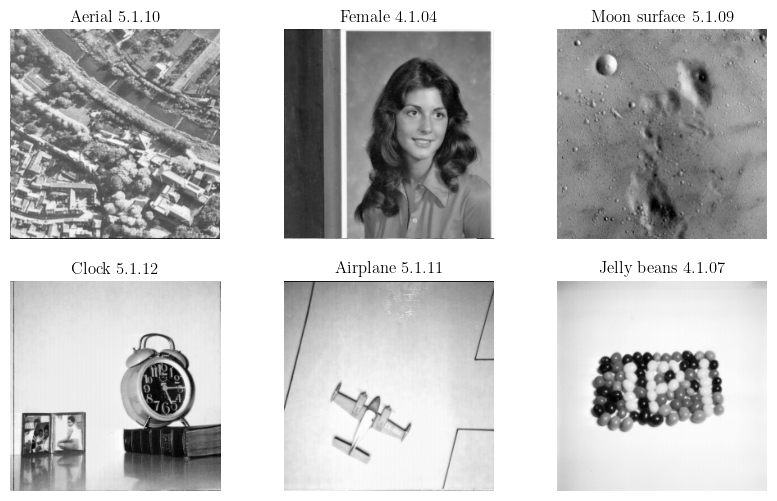

In [2]:
# Dictionary of image filenames
image_files = {
    'Aerial': 'sipi.usc.edu_misc/misc/5.1.10.tiff',
    'Female': 'sipi.usc.edu_misc/misc/4.1.04.tiff',
    'Moon': 'sipi.usc.edu_misc/misc/5.1.09.tiff',
    'Clock': 'sipi.usc.edu_misc/misc/5.1.12.tiff',
    'Airplane': 'sipi.usc.edu_misc/misc/5.1.11.tiff',
    'Jelly': 'sipi.usc.edu_misc/misc/4.1.07.tiff'
}

# Corresponding display titles
display_titles = {
    'Aerial': 'Aerial 5.1.10',
    'Female': 'Female 4.1.04',
    'Moon': 'Moon surface 5.1.09',
    'Clock': 'Clock 5.1.12',
    'Airplane': 'Airplane 5.1.11',
    'Jelly': 'Jelly beans 4.1.07'
}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

# Load images into a dictionary
images = {name: np.array(Image.open(file).convert('L')).astype(np.uint8)
          for name, file in image_files.items()}

# Set up the plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Display images with the corresponding titles
for ax, (name, image) in zip(axes.flatten(), images.items()):
    ax.imshow(image, cmap='gray')
    ax.set_title(display_titles[name])
    ax.axis('off')

plt.savefig('images', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='pdf',
        transparent=False, bbox_inches='tight', pad_inches=.1,
        )
plt.show()

# Two ways of MCNOT cost calculations

In [3]:
def mcnot_qc(m):
    '''
    The QC of MCNOT without any ancillary qubits, described in Barenco et al.
    m = number of control qubits
    The QC of Toffoli and CNOT gates are 6 and 1, respectively.
    '''
    if m>2:
        return 3* (2**m) - 4
    elif m==2:
        return 6
    elif m==1:
        return 1

def mcnotR_qc(m):
    '''
    The QC of MCNOT-R with 2 ancillary qubits, described in Iranmanesh et al.
    m = number of control qubits
    The QC of Toffoli and CNOT gates are 6 and 1, respectively.
    '''
    if m>2:
        return 19*m - 32
    elif m==2:
        return 6
    elif m==1:
        return 1

# QC without Optimization

In [4]:
def QC_old(image, mcnot):
    '''
    image_binary is a matrix which has rows as many pixel positions and columns as many
    grayscale bits.
    A matrix in which each column indicates the "b" vector of the specified grayscale bit.
    Each row is in a descending order (7 to 0). 
    As an example for a row, 56 -> array([0, 0, 1, 1, 1, 0, 0, 0], dtype=uint8)
    
    Each column of "i" indicates which pixel positions should convert the 
    grayscale qubit of "i" from 0 to 1, meaning that each 1s in this column 
    indicates how many MCNOTs required for the grayscale qubit of "i".
    
    mcnot: mcnot_qc(m), mcnotR_qc(m)
    '''
    dim1 = image.shape[0]
    dim2 = image.shape[1]
    # m = number of control qubits
    m = np.log2(dim1*dim2)
    image_binary = np.unpackbits(image, axis=1, bitorder='big').reshape(dim1*dim2, 8)

    return np.count_nonzero(image_binary) * mcnot(m)


In [5]:
print(QC_old(images['Aerial'], mcnot_qc))

print(QC_old(images['Female'], mcnot_qc))

print(QC_old(images['Moon'], mcnot_qc))

print(QC_old(images['Clock'], mcnot_qc))

print(QC_old(images['Airplane'], mcnot_qc))

print(QC_old(images['Jelly'], mcnot_qc))

53865957128.0
50562026908.0
50633394160.0
58309797340.0
56223632296.0
53324902920.0


In [6]:
print(QC_old(images['Aerial'], mcnotR_qc))

print(QC_old(images['Female'], mcnotR_qc))

print(QC_old(images['Moon'], mcnotR_qc))

print(QC_old(images['Clock'], mcnotR_qc))

print(QC_old(images['Airplane'], mcnotR_qc))

print(QC_old(images['Jelly'], mcnotR_qc))

74523104.0
69952144.0
70050880.0
80671120.0
77784928.0
73774560.0


# ***************************************

# PPRM

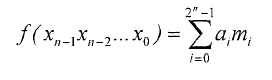         Sum of Products (SOP)

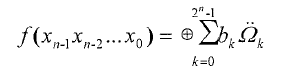    Exclusive-or Sum-of-Products‬‬‫‪‬‬ (ESOP)

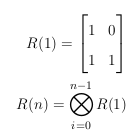  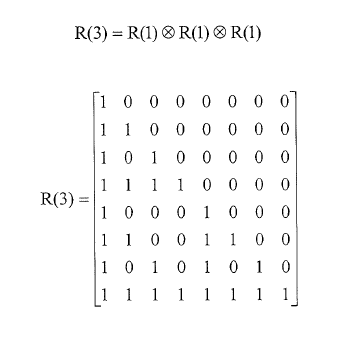   

In [3]:
def R(k):
    '''Non-Recursive RM_Transform_Matrix'''
    R1 = np.array([[1, 0],
                   [1, 1]], dtype=np.uint8)
    if k == 1:
        return R1
    
    result = R1
    for _ in range(1, k):
        result = np.kron(result, R1)
        
    return result

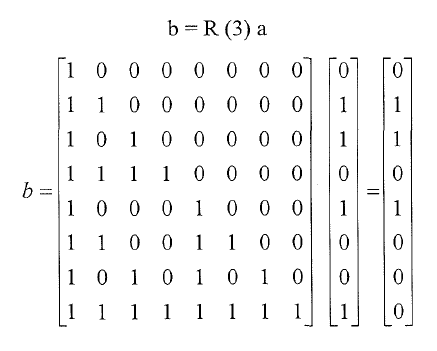

In [22]:
k=3
a = np.array([[0],
              [1],
              [1],
              [0],
              [1],
              [0],
              [0],
              [1]])

b = np.dot(R(k), a) % 2
b

array([[0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0]])

### Binary_PPRM instead of calculating R(k) and  b = np.dot(R(k), a) % 2

In [4]:
def Binary_PPRM_old(a, k):
    # Create a copy of a to avoid modifying the input list
    a_copy = a.copy()
    
    blocksize = 1
    for n in range(k):
        source = 0
        while source < 2**k:
            target = source + blocksize
            for i in range(blocksize):
                a_copy[target + i] = a_copy[target + i] ^ a_copy[source + i]
            source += 2 * blocksize
        blocksize *= 2
    return a_copy


mask = 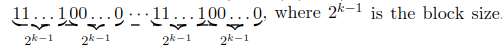

In [5]:
def Binary_PPRM(a, k):
    blocksize = 1
    for i in range(k):
        mask = np.array([[1]*(2**i), [0]*(2**i)]*(2**(k-(i+1)))).reshape(2**k,1)
        temp = np.zeros_like(a)
        # temp = a_masked SHR(shift right) blocksize
        temp[blocksize:] = (a & mask)[:-blocksize]
        # XOR between all blocks
        a = a ^ temp; 
        blocksize *= 2
    return a

### Testing runtime 

In [8]:
time0 = time.perf_counter_ns()

k=14
a = np.random.randint(0, 2, size=(2**k, 1))

result = np.dot(R(k), a) % 2

time1= time.perf_counter_ns() - time0

print("time1:", time1/(10**9), " seconds")

time1: 3.972985441  seconds


In [9]:
time0 = time.perf_counter_ns()

k=14
a = np.random.randint(0, 2, size=(2**k, 1))

result = Binary_PPRM_old(a, k)

time1= time.perf_counter_ns() - time0

print("time1:", time1/(10**9), " seconds")

time1: 0.163577451  seconds


In [10]:
time0 = time.perf_counter_ns()

k=14
a = np.random.randint(0, 2, size=(2**k, 1))

result = Binary_PPRM(a, k)

time1= time.perf_counter_ns() - time0

print("time1:", time1/(10**9), " seconds")

time1: 0.032855811  seconds


# *************************************************
### PPRM Expressions

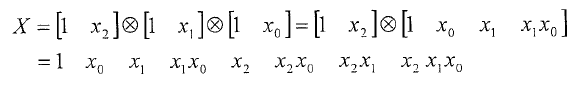

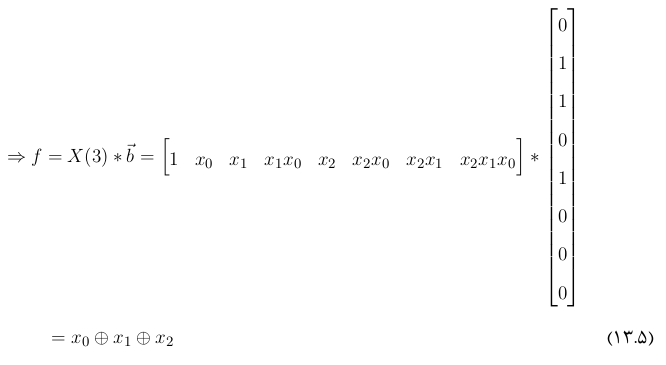

In [8]:
time0 = time.perf_counter_ns()

class PPRM:
    
    def __init__(self, a):
        '''
        a: input vector, indicating the coefficients of f 
        '''
        self.a = a.astype(np.uint8)
        self.k = np.log2(self.a.shape[0]).astype(np.uint8)
        self.b = self.Binary_PPRM(self.a, self.k)
        self.X = self.X(self.k)

    
    def Binary_PPRM(self, a, k):
        blocksize = 1
        for i in range(k):
            mask = np.array([[1]*(2**i), [0]*(2**i)]*(2**(k-(i+1)))).reshape(2**k,1).astype(np.uint8)
            temp = np.zeros_like(a)
            # temp = a_masked SHR(shift right) blocksize
            temp[blocksize:] = (a & mask)[:-blocksize]
            # XOR between all blocks
            a = a ^ temp; 
            blocksize *= 2
        return a


    def x_product(self, x_i, x_j):
        '''
        x_i: [i],  x_j: [j]
        x_product([i], [j]) = [i, j]   : x_i . x_j
        x_product(x_i, 1) = [i]        : x_i . 1 = x_i

        For example:
           rm_concat([2], 1) = [2]            : x2 . 1 = x2
           rm_concat([2], [0]) = [0, 2]       : x0 . x2 
           rm_concat([0, 1], [2]) = [0, 1, 2] : x0 . x1 . x2
       '''
        if x_i == 1:
            return x_j
        if x_j == 1:
            return x_i
        return list(np.concatenate((x_j, x_i)))
    

    def x_kron(self, list2, list1):
        ''' kronecker product of lists of product terms
            x_kron([1,[1]], [1,[0]]) = [1, [0], [1], [0, 1]]
        '''
        output = list1
        for i in range(len(list1)):
            output.append(self.x_product(list2[1], list1[i]))
        return output
    

    def X(self, k):
        # time0 = time.perf_counter_ns()
        '''
        X(1) = [1, [0]]               : 1 xor x0

        X(2) = [1, [0], [1], [0, 1]]  : 1 xor x0 xor x1 xor x0.x1
                
        X(3) = [1, [0], [1], [0, 1], [2], [0, 2], [1, 2], [0, 1, 2]] 
        '''
        if k == 1:
            return [1, [0]]
        if k == 2:
            return self.x_kron([1, [1]], [1, [0]])

        result = [1, [0]]  # Start with the result for k = 1
        for i in range(2, k+1):
            result = self.x_kron([1, [i-1]], result)
            
        # time1= time.perf_counter_ns() - time0
        # print("time1:", time1/(10**9), " seconds")
        return result


    
    def pprm(self):
        ''' Returns a list indicating which product terms are required
        for the new PPRM expression.

        For example:

            b = array([[0],
                       [1],
                       [1],
                       [0],
                       [1],
                       [0],
                       [0],
                       [0]])

            pprm() = [[0], [1], [2]]  : x0 xor x1 xor x2
        '''
        result = []
        idx_ones_in_b = np.argwhere(self.b == 1)[:, 0].reshape(-1)
        for idx in idx_ones_in_b:
            result.append(self.X[idx])
        return result

# Usage
a = np.array([[0],
              [1],
              [1],
              [0],
              [1],
              [0],
              [0],
              [1]])
# k=3
# a = np.random.randint(0, 2, size=(2**k, 1))

pprm_instance = PPRM(a)
result = pprm_instance.pprm()
print(result)

time1= time.perf_counter_ns() - time0

print("time1:", time1/(10**9), " seconds")


[1, [1], [2], [1, 2]]
time1: 0.025424416  seconds


# Calculate PPRM QC

In [13]:
def QC(image, mcnot):
    '''mcnot: mcnot_qc or mcnotR_qc'''
    dim1 = image.shape[0]
    dim2 = image.shape[1]
    qc_sum = 0
    image_binary = np.unpackbits(image, axis=1, bitorder='big').reshape(dim1*dim2, 8).astype(np.uint8)
    
    for i in range(8):
        a = image_binary[:, i].reshape(-1, 1)
        pprm_instance = PPRM(a)
        pprm = pprm_instance.pprm()
    
        for product_term in pprm:
            # Skip the QC of X Gates
            if product_term == 1:
                continue
            else:
                # len(product_term) = the number of control qubits of the MCNOT
                qc_sum = qc_sum + mcnot(len(product_term))
    return qc_sum

    

In [14]:
print(QC(images['Aerial'], mcnot_qc))

print(QC(images['Female'], mcnot_qc))

print(QC(images['Moon'], mcnot_qc))

print(QC(images['Clock'], mcnot_qc))

print(QC(images['Airplane'], mcnot_qc))

print(QC(images['Jelly'], mcnot_qc))

514219033
508945459
517464591
506508163
516989043
497631277


In [26]:
print(QC(images['Aerial'], mcnotR_qc))

print(QC(images['Female'], mcnotR_qc))

print(QC(images['Moon'], mcnotR_qc))

print(QC(images['Clock'], mcnotR_qc))

print(QC(images['Airplane'], mcnotR_qc))

print(QC(images['Jelly'], mcnotR_qc))

31476768
30483500
31264133
30194410
30924631
28723803


In [11]:
(53865957128 + 50562026908 + 50633394160 + 58309797340 + 56223632296 + 53324902920)/(514219033 + 508945459 + 517464591 + 506508163 + 516989043 + 497631277)

105.4687393730768

In [12]:
(74523104 + 69952144.0 + 70050880.0 + 80671120.0 + 77784928.0 + 73774560.0)/(31476768+30483500+31264133+30194410+30924631+28723803)

2.4403968935021663